In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):

    train_set_one = train_set
#     START AUGMENTING
    LABEL = []
    # select random indices
    number_of_rows = int(train_set_one.shape[0] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_one.shape[0]-1, size=int(number_of_rows), replace=False))
    train_set_one = train_set_one[random_indices,:]
    
    
    train_set_one = train_set_one.transpose()
    if function == 'scale':
        train_set_one = DA_Scaling(train_set_one)
    elif function == 'jitter':
        train_set_one = DA_Jitter(train_set_one)
    elif function == 'magWarp':
        train_set_one = DA_MagWarp(train_set_one)
    elif function == 'timeWarp':
        train_set_one = DA_TimeWarp(train_set_one)
    elif function == 'rotation':
        train_set_one = DA_Rotation(train_set_one)
    elif function == 'permutation':
        train_set_one = DA_Permutation(train_set_one)
    else:
        print("Error no augmentation function")
        return -1
    train_set_one = train_set_one.transpose()
        
    
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, train_set_one), axis = 0)
    print(train_set[0,0])
    print(train_set_one[0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented



In [4]:
def model_network(learning_rate, unit):
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)
        

    model = Sequential()
    model.add(Input(shape=(2400,)))
    model.add(layers.BatchNormalization())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(units=unit, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     opt = SGD(learning_rate=learning_rate,momentum=0.5)
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=learning_rate,momentum=0.4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',Recall(), Precision()])
    return model

In [5]:
# train_set = np.load('train_set_original.npy',  encoding='ASCII')
# train_label = np.load('train_label_original.npy',  encoding='ASCII')
# test_set = np.load('test_set.npy',  encoding='ASCII')
# test_label = np.load('test_label.npy',  encoding='ASCII')
# train_label = train_label.reshape(train_label.shape[0], 1)
# test_label = test_label.reshape(test_label.shape[0], 1)

# # real parameters(0.0001, 40)

# train_set_arr = train_set[0]
# test_set_arr = test_set[0]
# model=KerasClassifier(build_fn=model_network)
# params={"learning_rate":[0.001, 0.0001, 0.00001], "unit":[16, 32, 64, 128]}
# gs=GridSearchCV(estimator=model, param_grid=params,  cv=StratifiedShuffleSplit(n_splits=1))

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# history = gs.fit(train_set_arr, train_label, epochs=50, batch_size= 128, shuffle=True, verbose=0, callbacks=[callback])

# # callback = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
# # gs = gs.fit(x_train, y_train, epochs=500, batch_size= 128, callbacks = [callback])

# print("Best: %f using %s" % (gs.best_score_, gs.best_params_))


2022-06-09 14:36:19.781832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


evaluate original:  [1.4504761695861816, 0.6073509454727173, 0.719111979007721, 0.5601503849029541]


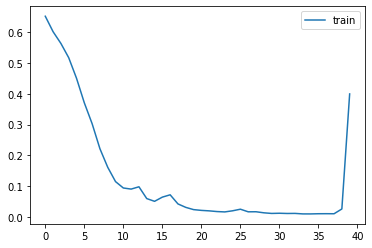

jitter
22.939411764705884
22.917921613094983
evaluate augmented :  jitter [2.4881417751312256, 0.6320036053657532, 0.6370656490325928, 0.5972850918769836]


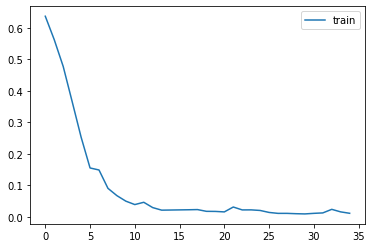

22.939411764705884
58.280558409261936
evaluate augmented :  jitter [2.586992025375366, 0.6467951536178589, 0.6167953610420227, 0.6203883290290833]


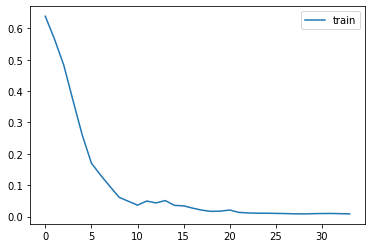

22.939411764705884
58.282125618837114
evaluate augmented :  jitter [2.693387508392334, 0.6337965130805969, 0.6476833820343018, 0.5975067019462585]


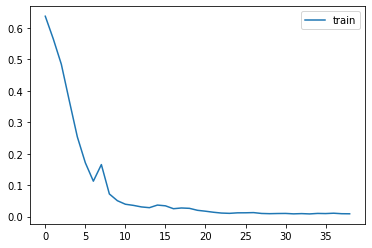

22.939411764705884
58.28069111542646
evaluate augmented :  jitter [2.6256637573242188, 0.6243836879730225, 0.626447856426239, 0.5899999737739563]


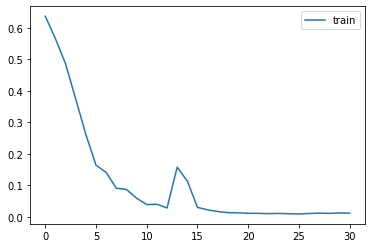

22.939411764705884
22.953515112607633
evaluate augmented :  jitter [2.86889386177063, 0.6216943264007568, 0.6303088665008545, 0.5861759185791016]


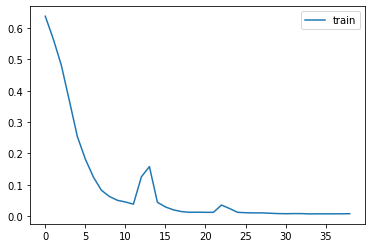

22.939411764705884
58.260100963030155
evaluate augmented :  jitter [2.764536142349243, 0.6355894207954407, 0.6245173811912537, 0.6041083335876465]


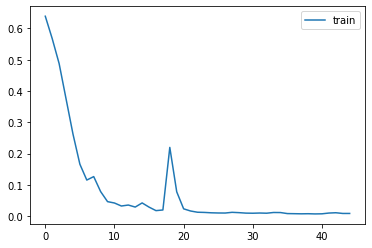

22.939411764705884
22.952318824020843
evaluate augmented :  jitter [2.5141701698303223, 0.64007169008255, 0.6245173811912537, 0.6098020672798157]


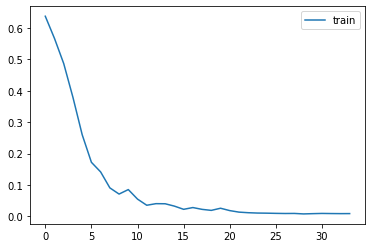

22.939411764705884
22.958346459020806
evaluate augmented :  jitter [2.4318718910217285, 0.627521276473999, 0.6361004114151001, 0.5920934677124023]


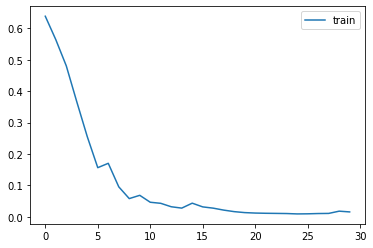

22.939411764705884
22.94734555394852
evaluate augmented :  jitter [2.880340337753296, 0.6355894207954407, 0.5945945978164673, 0.6105054616928101]


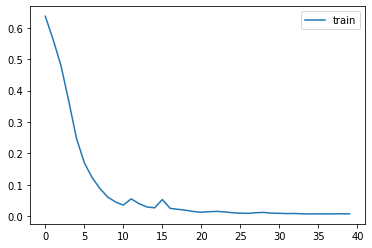

22.939411764705884
-61.58902927020979
evaluate augmented :  jitter [1.9604921340942383, 0.6212460994720459, 0.6042470932006836, 0.5900094509124756]


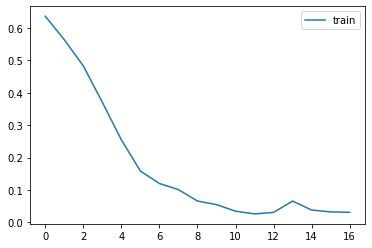

[0.6320036053657532, 0.6467951536178589, 0.6337965130805969, 0.6243836879730225, 0.6216943264007568, 0.6355894207954407, 0.64007169008255, 0.627521276473999, 0.6355894207954407, 0.6212460994720459]
[0.6370656490325928, 0.6167953610420227, 0.6476833820343018, 0.626447856426239, 0.6303088665008545, 0.6245173811912537, 0.6245173811912537, 0.6361004114151001, 0.5945945978164673, 0.6042470932006836]
[0.5972850918769836, 0.6203883290290833, 0.5975067019462585, 0.5899999737739563, 0.5861759185791016, 0.6041083335876465, 0.6098020672798157, 0.5920934677124023, 0.6105054616928101, 0.5900094509124756]
mean: 0.6318691194057464 -- std: (+/- 0.007828111316403635
scale
22.939411764705884
23.129911209574527
evaluate augmented :  scale [2.261107921600342, 0.6239354610443115, 0.6669884324073792, 0.5831223726272583]


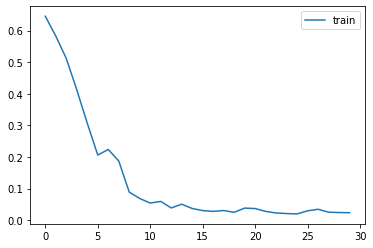

22.939411764705884
9.947234126645323
evaluate augmented :  scale [2.6192827224731445, 0.6369341015815735, 0.5907335877418518, 0.6132264733314514]


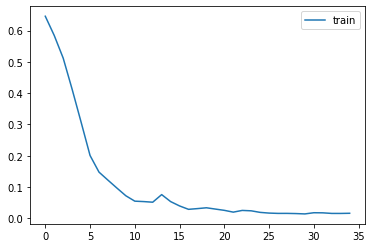

22.939411764705884
4.67037072131962
evaluate augmented :  scale [2.492748975753784, 0.6270730495452881, 0.5357142686843872, 0.612582802772522]


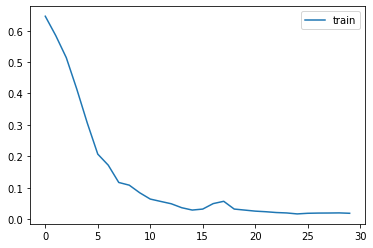

22.939411764705884
32.44919585950971
evaluate augmented :  scale [2.555605888366699, 0.6373823285102844, 0.5666022896766663, 0.6198521852493286]


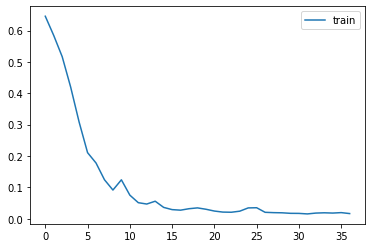

22.939411764705884
52.21866691794442
evaluate augmented :  scale [2.4676384925842285, 0.6320036053657532, 0.5540540814399719, 0.6152197122573853]


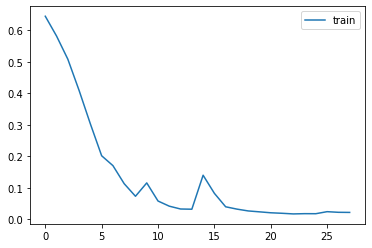

22.939411764705884
17.205071641196177
evaluate augmented :  scale [2.1739261150360107, 0.6167637705802917, 0.6428571343421936, 0.5786272883415222]


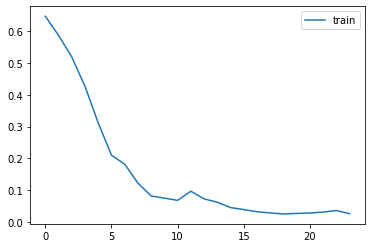

22.939411764705884
10.679480160035455
evaluate augmented :  scale [2.0784995555877686, 0.6297624111175537, 0.6003860831260681, 0.601547360420227]


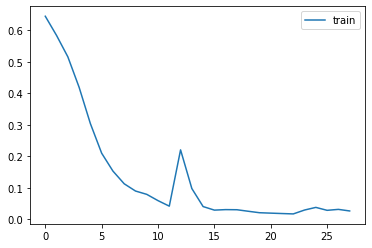

22.939411764705884
43.765395251713386
evaluate augmented :  scale [2.4827470779418945, 0.6234872341156006, 0.6631274223327637, 0.5831918716430664]


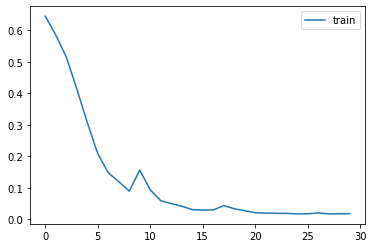

22.939411764705884
14.604060350329362
evaluate augmented :  scale [2.54779052734375, 0.6284177303314209, 0.5762548446655273, 0.6048632264137268]


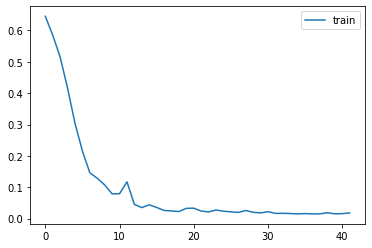

22.939411764705884
32.550048016772664
evaluate augmented :  scale [2.3586676120758057, 0.6172119975090027, 0.53861004114151, 0.597430408000946]


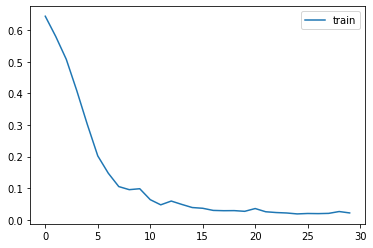

[0.6239354610443115, 0.6369341015815735, 0.6270730495452881, 0.6373823285102844, 0.6320036053657532, 0.6167637705802917, 0.6297624111175537, 0.6234872341156006, 0.6284177303314209, 0.6172119975090027]
[0.6669884324073792, 0.5907335877418518, 0.5357142686843872, 0.5666022896766663, 0.5540540814399719, 0.6428571343421936, 0.6003860831260681, 0.6631274223327637, 0.5762548446655273, 0.53861004114151]
[0.5831223726272583, 0.6132264733314514, 0.612582802772522, 0.6198521852493286, 0.6152197122573853, 0.5786272883415222, 0.601547360420227, 0.5831918716430664, 0.6048632264137268, 0.597430408000946]
mean: 0.627297168970108 -- std: (+/- 0.006801430817070874
magWarp
22.939411764705884
72.84271991843003
evaluate augmented :  magWarp [1.954943060874939, 0.6270730495452881, 0.63416987657547, 0.591891884803772]


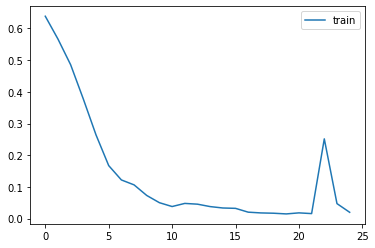

22.939411764705884
28.885848454498497
evaluate augmented :  magWarp [2.279956579208374, 0.6252801418304443, 0.6698841452598572, 0.5841751098632812]


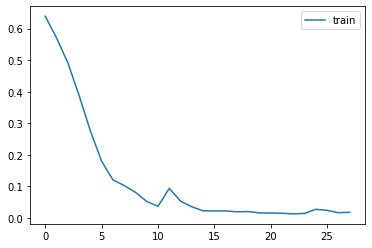

22.939411764705884
20.17893393564411
evaluate augmented :  magWarp [2.5820071697235107, 0.620797872543335, 0.7046331763267517, 0.5748031735420227]


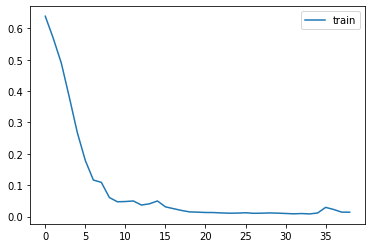

22.939411764705884
23.30740915445297
evaluate augmented :  magWarp [2.5636966228485107, 0.62796950340271, 0.6023166179656982, 0.5988483428955078]


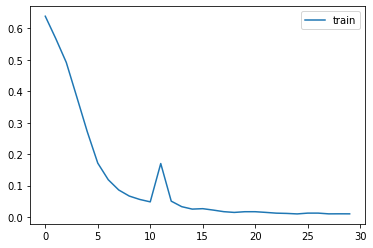

22.939411764705884
-88.03929473122032
evaluate augmented :  magWarp [2.592888116836548, 0.6199014186859131, 0.7084941864013672, 0.573437511920929]


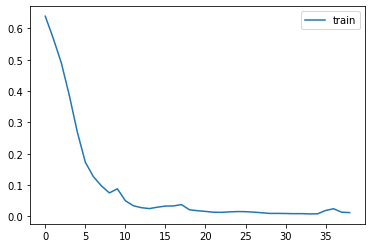

22.939411764705884
22.44590842848632
evaluate augmented :  magWarp [2.249717950820923, 0.6190049052238464, 0.6370656490325928, 0.5820105671882629]


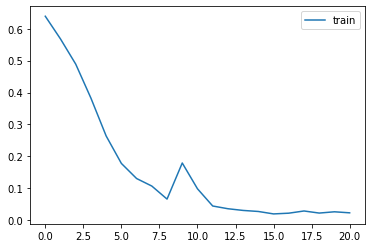

22.939411764705884
-16.626030686459586
evaluate augmented :  magWarp [2.3940682411193848, 0.6297624111175537, 0.6196911334991455, 0.5977653861045837]


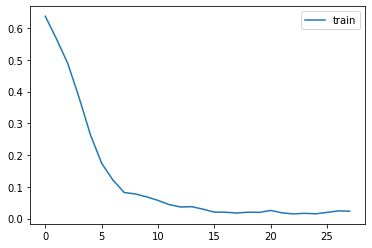

22.939411764705884
20.838051551379237
evaluate augmented :  magWarp [2.2568607330322266, 0.6378305554389954, 0.6756756901741028, 0.5972696542739868]


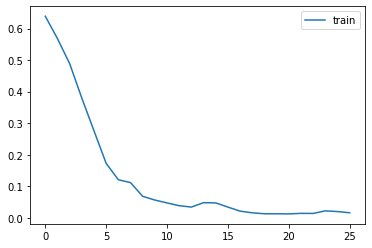

22.939411764705884
24.705158638208324
evaluate augmented :  magWarp [2.2135679721832275, 0.6369341015815735, 0.6409266591072083, 0.6025408506393433]


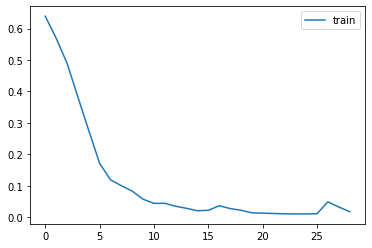

22.939411764705884
-13.775136966150306
evaluate augmented :  magWarp [2.262669563293457, 0.6311071515083313, 0.6370656490325928, 0.5962059497833252]


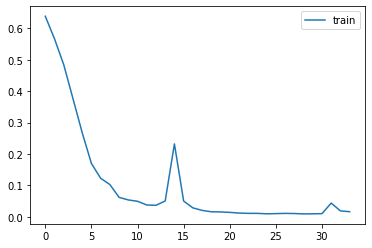

[0.6270730495452881, 0.6252801418304443, 0.620797872543335, 0.62796950340271, 0.6199014186859131, 0.6190049052238464, 0.6297624111175537, 0.6378305554389954, 0.6369341015815735, 0.6311071515083313]
[0.63416987657547, 0.6698841452598572, 0.7046331763267517, 0.6023166179656982, 0.7084941864013672, 0.6370656490325928, 0.6196911334991455, 0.6756756901741028, 0.6409266591072083, 0.6370656490325928]
[0.591891884803772, 0.5841751098632812, 0.5748031735420227, 0.5988483428955078, 0.573437511920929, 0.5820105671882629, 0.5977653861045837, 0.5972696542739868, 0.6025408506393433, 0.5962059497833252]
mean: 0.627566111087799 -- std: (+/- 0.006276647702046653
timeWarp
22.939411764705884
-61.592352941176465
evaluate augmented :  timeWarp [2.4589245319366455, 0.658449113368988, 0.59555983543396, 0.6427083611488342]


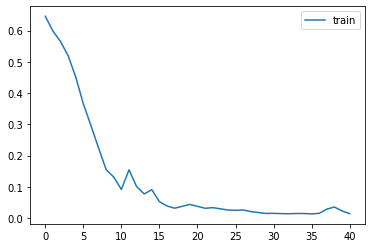

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.476736307144165, 0.6391752362251282, 0.5965250730514526, 0.6149253845214844]


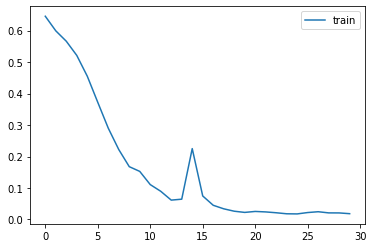

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.2109086513519287, 0.6369341015815735, 0.6119691133499146, 0.6084452867507935]


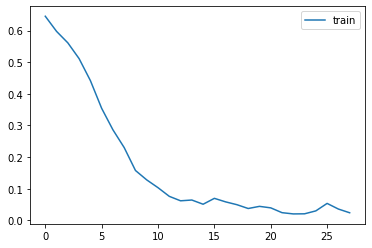

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.1630923748016357, 0.6252801418304443, 0.6370656490325928, 0.5892857313156128]


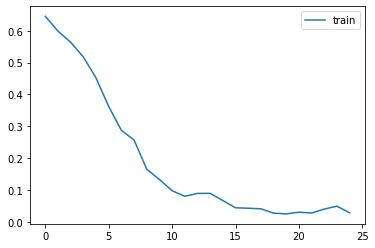

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.2195136547088623, 0.6441057920455933, 0.6679536700248718, 0.6059544682502747]


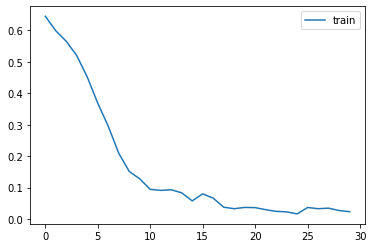

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.334973096847534, 0.6216943264007568, 0.7490347623825073, 0.570588231086731]


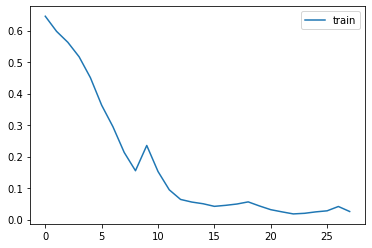

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.475160837173462, 0.64007169008255, 0.5279922485351562, 0.635307788848877]


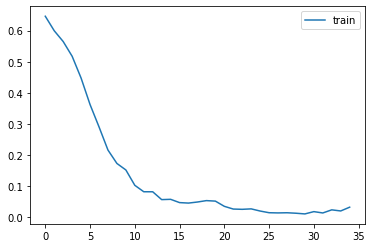

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.572711944580078, 0.6418646574020386, 0.6312741041183472, 0.6106442809104919]


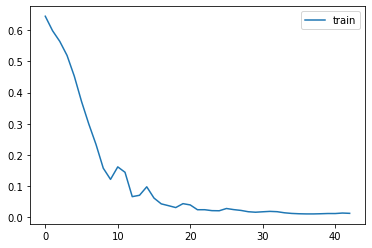

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.2237558364868164, 0.6293141841888428, 0.6438223719596863, 0.5928888916969299]


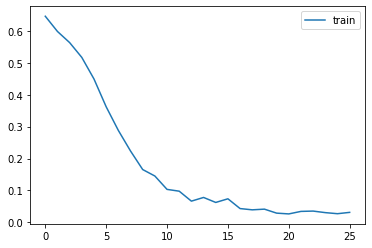

22.939411764705884
22.939411764705884
evaluate augmented :  timeWarp [2.3689053058624268, 0.645898699760437, 0.6640926599502563, 0.6088495850563049]


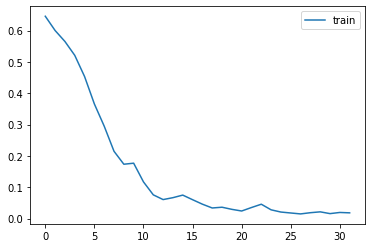

[0.658449113368988, 0.6391752362251282, 0.6369341015815735, 0.6252801418304443, 0.6441057920455933, 0.6216943264007568, 0.64007169008255, 0.6418646574020386, 0.6293141841888428, 0.645898699760437]
[0.59555983543396, 0.5965250730514526, 0.6119691133499146, 0.6370656490325928, 0.6679536700248718, 0.7490347623825073, 0.5279922485351562, 0.6312741041183472, 0.6438223719596863, 0.6640926599502563]
[0.6427083611488342, 0.6149253845214844, 0.6084452867507935, 0.5892857313156128, 0.6059544682502747, 0.570588231086731, 0.635307788848877, 0.6106442809104919, 0.5928888916969299, 0.6088495850563049]
mean: 0.6382787942886352 -- std: (+/- 0.010207434081952566
permutation
22.939411764705884
-10.076875
evaluate augmented :  permutation [2.3023602962493896, 0.6467951536178589, 0.6505791544914246, 0.6127272844314575]


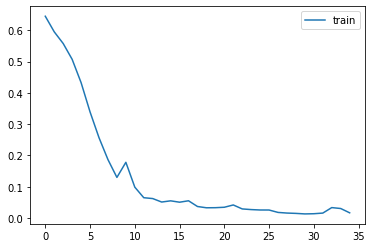

22.939411764705884
58.283529411764704
evaluate augmented :  permutation [2.4156994819641113, 0.6297624111175537, 0.5743243098258972, 0.6071428656578064]


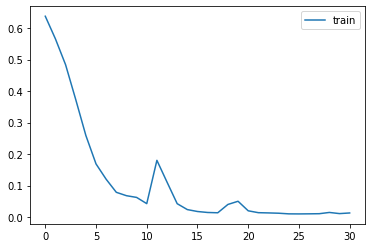

22.939411764705884
22.107499999999998
evaluate augmented :  permutation [2.071350574493408, 0.6382787823677063, 0.6042470932006836, 0.6119257211685181]


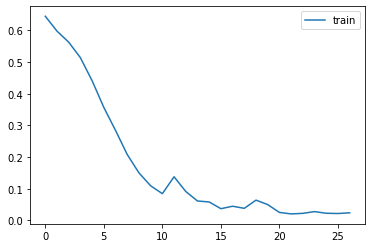

22.939411764705884
22.939411764705884
evaluate augmented :  permutation [2.3474786281585693, 0.6418646574020386, 0.5810810923576355, 0.6225439310073853]


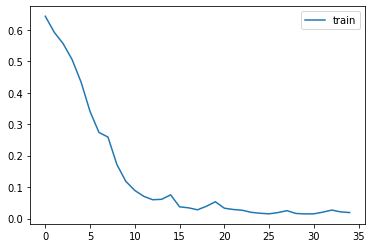

22.939411764705884
-27.79125
evaluate augmented :  permutation [2.493208169937134, 0.6414164304733276, 0.47297295928001404, 0.6586021780967712]


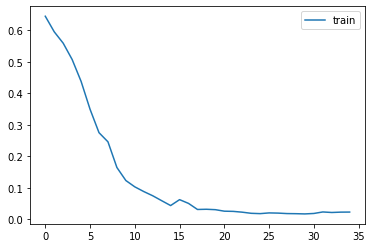

22.939411764705884
0.27749999999999997
evaluate augmented :  permutation [2.141148090362549, 0.6391752362251282, 0.6370656490325928, 0.6060606241226196]


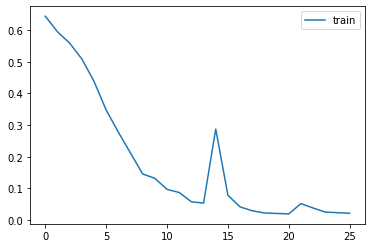

22.939411764705884
7.863125
evaluate augmented :  permutation [2.1189284324645996, 0.6293141841888428, 0.6303088665008545, 0.5952597856521606]


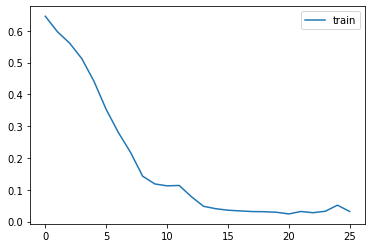

22.939411764705884
22.939411764705884
evaluate augmented :  permutation [2.411926507949829, 0.645898699760437, 0.626447856426239, 0.6169201731681824]


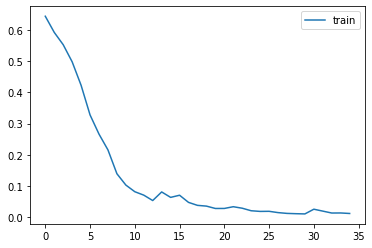

22.939411764705884
-16.96588235294118
evaluate augmented :  permutation [2.2085206508636475, 0.6436575651168823, 0.6785714030265808, 0.6034334897994995]


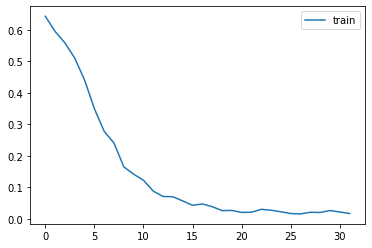

22.939411764705884
-58.086
evaluate augmented :  permutation [2.3226723670959473, 0.6351411938667297, 0.6428571343421936, 0.6000000238418579]


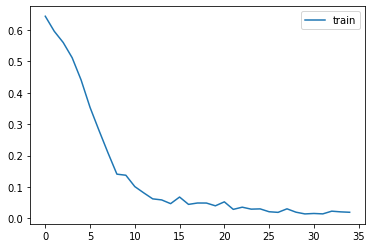

[0.6467951536178589, 0.6297624111175537, 0.6382787823677063, 0.6418646574020386, 0.6414164304733276, 0.6391752362251282, 0.6293141841888428, 0.645898699760437, 0.6436575651168823, 0.6351411938667297]
[0.6505791544914246, 0.5743243098258972, 0.6042470932006836, 0.5810810923576355, 0.47297295928001404, 0.6370656490325928, 0.6303088665008545, 0.626447856426239, 0.6785714030265808, 0.6428571343421936]
[0.6127272844314575, 0.6071428656578064, 0.6119257211685181, 0.6225439310073853, 0.6586021780967712, 0.6060606241226196, 0.5952597856521606, 0.6169201731681824, 0.6034334897994995, 0.6000000238418579]
mean: 0.6391304314136506 -- std: (+/- 0.005818195506565027


In [6]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
best_lr = 0.1
best_units = 100
epoch = 100
batch_s = 400

techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

line_csv_acc, line_csv_recall, line_csv_precision= [],[],[]
std_accuracy, std_recall, std_precision  = [],[],[]
arr_eda_percentage = []



train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)


train_set_arr = train_set[1]
test_set_arr = test_set[1]

# model = model_network(0.0001, 40)
model = model_network(best_lr, best_units)

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=epoch, batch_size= batch_s, shuffle=True, verbose=0, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
original_accuracy = scores1[1]
line_csv_acc.append(round(scores1[1]* 100,4))
line_csv_recall.append(round(scores1[2]* 100,4))
line_csv_precision.append(round(scores1[3]* 100,4))
std_accuracy.append(0)
std_recall.append(0)
std_precision.append(0)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
            
# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    
    recall_original = 0
    accuracies, recalls, precisions = [],[],[]
    
    tec_len = 10
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        
        train_set_arr_augment, label_set_augmented = augment_data(train_set[1], train_label, technique)
        
        test_set_arr = test_set[1]
        model = model_network(best_lr, best_units)

        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=epoch, batch_size= batch_s, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)
        #     --------------------------------------------------------------------
        print("evaluate augmented : ", technique, scores2)

        accuracies.append(scores2[1])
        recalls.append(scores2[2])
        precisions.append(scores2[3])

        
        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    line_csv_acc.append(round(np.mean(accuracies)* 100,4))
    line_csv_recall.append(round(np.mean(recalls)* 100,4))
    line_csv_precision.append(round(np.mean(precisions)* 100,4))
    std_accuracy.append(round(np.std(accuracies)* 100,4))
    std_recall.append(round(np.std(recalls)* 100,4))
    std_precision.append(round(np.std(precisions)* 100,4))
    print(accuracies)
    print(recalls)
    print(precisions)
    print("mean: {} -- std: (+/- {}".format(np.mean(accuracies), np.std(accuracies)))

    arr_eda_percentage.append(round((np.mean(accuracies) - original_accuracy) * 100, 4))



line_csv_acc.insert(0, 'BVP')
std_accuracy.insert(0, 'STD ACCURACY')
line_csv_recall.insert(0, 'RECALL')
std_recall.insert(0, 'STD RECALL')
line_csv_precision.insert(0, 'PRECISION')
std_precision.insert(0, 'STD PRECISION')



header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy_BVP.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(line_csv_acc)
    writer.writerow(std_accuracy)
    writer.writerow(line_csv_recall)
    writer.writerow(std_recall)
    writer.writerow(line_csv_precision)
    writer.writerow(std_precision)

    writer.writerow([])
    arr_eda_percentage.insert(0, 0)
    arr_eda_percentage.insert(0, 'BVP')
    writer.writerow(arr_eda_percentage)


